# Consistency Assessment of the Atlas Underpinning Dataset with Original #WIP

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**
Production date: DD-MM-YYYY
Dataset version: 2.0.
Produced by: C3S2_521 contract.

## 🌍 Use case: tbd 

## ❓ Quality assessment question
* **Are the output indexes consistent between the Gridded Dataset Underpinning the Copernicus Interactive Climate Atlas and the CMIP6 Climate Projections dataset?**
* **etc**

This box will be the introduction to the assessment, including:
- Purpose and aims of the assessment. 
- 

(NOTE: need to find the correct terminology when referring to the non-Atlas datasets throughout this, option: original origin datasets, non-Atlas datasets, ...  have chosen origin datasets)

The purpose of this assessment is to evaluate the consistency between the Gridded Dataset Underpinning the Copernicus Interactive Climate Atlas (Atlas dataset hereafter) and the origin datasets. This is done through 


## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1: will be a statement on the findings regarding the consistency 
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology

To include:
- *Dimensions of the Atlas dataset and the rationale behind the scope of this assessment*
Due to the extend of the Atlas

- Justification for the assessment being performed (justification for the t.b.d metric chosen also)
- Methodology used, i.e. each step:
  
      - Download model data
  
      - Set parameters (variable, time, location)
  
      - Load data
  
      - Homogenisation to match Atlas dataset
  
      - Calculate the index
  
      - Interpolate to a common and regular grid
  
      - Download corresponding Atlas dataset data
  
      - Analyse results
          - plots 
          - similarity/comparison metric
          - results matrix 

Part 1 is an in depth look at the tx35 index from the CMIP6 dataset over Spain to explain the methodology 
The purpose of Part 1 is to explain to the users what is being done, demonstrate how they can do their own version of this study for their own region of interest and index, and 

Part 2 is the full scale study the extent of this is ....

This Jupyter notebook is currently a test case to build the workflow. We have chosen to reproduce the [Monthly count of days with maximum near-surface air temperature above 35 deg](https://ecmwf-projects.github.io/c3s-atlas/notebooks/tx35.html) notebook as an initial test. 

**[](section-1)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-2)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-3)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-4)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.
 
**[](section-5)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-6)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-7)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-8)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

Any further notes on the method could go here (explanations, caveats or limitations).

## 📈 Analysis and results

(section-1)=
### 1. Code setup 
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for 
downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) 
and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data.
Because earthkit is in active development, some functionality may change after this notebook is published.
If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Install the C3S Atlas User Tools
This notebook uses the [C3S Atlas User Tools](https://github.com/ecmwf-projects/c3s-atlas), which can be installed with the following cell. Further details and alternative options for installing this library are available in its [README file](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements).



In [46]:
pip install git+https://github.com/ecmwf-projects/c3s-atlas.git

  Cloning https://github.com/ecmwf-projects/c3s-atlas.git to /tmp/pip-req-build-u5m808ju
  Running command git clone --filter=blob:none --quiet https://github.com/ecmwf-projects/c3s-atlas.git /tmp/pip-req-build-u5m808ju
  Resolved https://github.com/ecmwf-projects/c3s-atlas.git to commit 80256810cb81aa78ab53033479e08cff6a8add44
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


The following cell imports all the necessary packages.

In [1]:
# Imports

# For reading files
from pathlib import Path

# For accessing data in the Climate Data Store
import earthkit.data

# For calculating spatiotemporal aggregations
import earthkit.transforms

# For regridding and interpolations
import earthkit.regrid
from earthkit.regrid import interpolate

# For climate data handling
import numpy as np
import xarray as xr
import xclim

# For plotting 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# For standarsising the data (NR rewrite this)
from c3s_atlas.fixers import (
    apply_fixers
)

# For regridding 
import c3s_atlas.interpolation as xesmfCICA

from c3s_atlas.utils import (
    plot_month
)

# For calculating metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error

/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


(section-2)=
### 2. Download Climate Data

#### General setup
This notebook uses [<u>earthkit-data<u>](https://github.com/ecmwf/earthkit-data) to download files from the CDS. If you intend to run this notebook multiple times, it is highly recommended that you [<u>enable caching<u>](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.


*(note: section 2 will be functions if they are neccessary)*
The following cell uses [earthkit](https://earthkit-data.readthedocs.io/en/latest/index.html) to download the data from the origin dataset.

In [36]:
#note to NR be unconnected from NPL wifi and VPN to run this cell 
# Use earthkit to download some data (Decided to unpack the dictionary as this is how it is in official docs)

# Define request
CMIP6_ID = "projections-cmip6"
request_CMIP6_tx35 = {
    "temporal_resolution": "daily",
    "experiment": "ssp5_8_5",
    "variable": "daily_maximum_near_surface_air_temperature",
    "model": "cmcc_esm2",
    "year": ["2080"],
    "month": [f"{month:02d}" for month in range(1, 13)],
    "day": [f"{day:02d}" for day in range(1, 32)],
    "format": "netcdf"
}

# For this example case we will be investigating 2060 and 2080 so we define the requests for these 
request_year_2060 = {"year": ["2060"]}
request_year_2080 = {"year": ["2080"]}



In [43]:
def make_full_request(request_dataset: dict, *requests: dict) -> dict:
    """ 
    Combine default requests (everything except year) with a year-specific request (request_year_20xx).
    """
    base_request = request_dataset
    updated_requests = [base_request | req for req in requests]
    return updated_requests


requests_CMIP6_combined = make_full_request(request_CMIP6_tx35, request_year_2060, request_year_2080)

# Download data
ds_CMIP6 = earthkit.data.from_source("cds", CMIP6_ID, *requests_CMIP6_combined)

print(ds)

2025-09-07 13:51:22,058 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 88.54it/s]
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/file-fe5c5a0790dbb23e9d86bf6a658b86650e54f397b39365b95c2af98bd1f1ec7f.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\n\xd3\x00\x00\x03"\x08\x02\x00\x00\x00\x99\xec9+\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/file-7ebf06b3b4473dba2486116d65db48de0ab2da5425703122f3defd795b70a46e.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\n\xd3\x00\x00\x03"\x08\x02\x00\x00\x00\x99\xec9+\x00\x00\x00\x06bKGD\x

NetCDFMultiFieldList(NetCDFFieldListReader(/tmp/earthkit-data-nr2/file-fe5c5a0790dbb23e9d86bf6a658b86650e54f397b39365b95c2af98bd1f1ec7f.d/tasmax_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20600101-20601231.nc),NetCDFFieldListReader(/tmp/earthkit-data-nr2/file-7ebf06b3b4473dba2486116d65db48de0ab2da5425703122f3defd795b70a46e.d/tasmax_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20800101-20801231.nc))


(section-3)=
### 3. Load the data

The following cell loads the file with [xarray](https://docs.xarray.dev/en/stable/)

In [44]:
# load files
#data = xr.open_dataset(ds)


print("CMIP6 data type from earthkit-data:", type(ds_CMIP6))
data_CMIP6 = ds_CMIP6.to_xarray(compat="equals")
print("CMIP6 data type in Xarray:", type(data_CMIP6))
data_CMIP6

CMIP6 data type from earthkit-data: <class 'earthkit.data.readers.netcdf.fieldlist.NetCDFMultiFieldList'>
CMIP6 data type in Xarray: <class 'xarray.core.dataset.Dataset'>


/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  return xr.open_mfdataset(


<xarray.Dataset> Size: 167MB
Dimensions:    (time: 730, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 6kB 2060-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 12kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 2MB dask.array<chunksize=(365, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 3MB dask.array<chunksize=(365, 288, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 161MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/a1513d6f-5325-4b99-bbe6-9b096557b100

(section-4)=
### 4. Homogenisation #NR rewrite

Once the data is downloaded from the CDS it undergoes a process of homogenization:

- The metadata of the spatial coordinates is homogenised to use standard names, in particular [lon, lat].

- Fix any non-standard calendars used in the data. This typically involves converting the calendars to the CF standard calendar (Mixed Gregorian/Julian) commonly used in climate data.

- Convert the units of the data to a common format (e.g. Celsius for temperature). This prevents us from working with the same variables in different units, for example.

- Convert the longitude values from the [0, 360] format to the [-180, 180] one. This is done to ensure that the longitude variable is common between the different datasets.

- Aggregated to the required temporal resolution. For example, hourly datasets (such as ERA5, ERA5-Land, WFDE5, etc.) will be resampled to daily resolution. This involves using a temporal aggregation method, such as taking the maximum or minimum value for a given variable. As part of this last step, some variable transformations are necessarily applied. For instance, fluxes variables in ERA5 are accumulated, and therefore, the last hour of the day represent daily accumulations. To mention another case, the surface wind is computed as a combination of both the u- and v-components.

In [45]:
# Homogenisation code 
project_id = "cmip6"
variable = 'tasmax'
var_mapping = {
            "dataset_variable": {"tasmax": "data"},
            "aggregation": {"data": "mean"},
        }
data_CMIP6 = apply_fixers(data_CMIP6, variable, project_id, var_mapping)
data_CMIP6

2025-09-07 13:54:47,829 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-09-07 13:54:48,147 — UNITS_TRANSFORM — INFO — The dataset tasmax units are not in the correct magnitude. A conversion from K to Celsius will be performed.
2025-09-07 13:54:48,639 — Homogenization-fixers — INFO — The dataset is in daily or monthly resolution, we don't need to resample it from hourly frequency


<xarray.Dataset> Size: 56MB
Dimensions:  (lat: 192, lon: 288, time: 252)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB -178.8 -177.5 -176.2 -175.0 ... 177.5 178.8 180.0
  * time     (time) datetime64[ns] 2kB 2060-01-01 2060-02-01 ... 2080-12-01
    height   float64 8B 2.0
Data variables:
    tasmax   (time, lat, lon) float32 56MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/a1513d6f-5325-4b99-bbe6-9b096557b100

(section-5)= 
### 5. Calculate index (tx35) and aggregate to monthly (MS) temporal resolution using xclim

[xclim](https://xclim.readthedocs.io/en/stable/) is an operational Python library for climate services, providing a framework for constructing custom climate indicators and indices.

In [5]:
# original order
# code to calculate tx35 and change temporal resolution 
da_tx35 = xclim.indices.tx_days_above(data['tasmax'], thresh='35.0 degC', 
                                      freq='MS', op='>') # "freq" attribute indicates output time frequency following pandas timeserie codes

# Convert DataArray to Dataset with specified variable name
ds_tx35 = da_tx35.to_dataset(name='tx35')
ds_tx35

# interpolate data original order
int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : np.arange(-89.5, 90.5, 1),
            'lons' : np.arange(-179.5, 180.5, 1),
            'var_name' : 'tx35'
}

INTER = xesmfCICA.Interpolator(int_attr)

ds_tx35_i = INTER(ds_tx35)

ds_tx35_i

/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


<xarray.Dataset> Size: 6MB
Dimensions:   (lon: 360, lat: 180, time: 12, bnds: 2)
Coordinates:
  * lon       (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time      (time) datetime64[ns] 96B 2080-01-01 2080-02-01 ... 2080-12-01
Dimensions without coordinates: bnds
Data variables:
    tx35      (time, lat, lon) int64 6MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    lon_bnds  (lon, bnds) float64 6kB -180.0 -179.0 -179.0 ... 179.0 179.0 180.0
    lat_bnds  (lat, bnds) float64 3kB -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    crs       int64 8B 0
    height    float64 8B 2.0

(section-6)= 
### 6. Interpolation to a common and regular grid
```{note}
This notebook uses [xESMF](https://github.com/pangeo-data/xESMF) for regridding data.
xESMF is most easily installed using conda as explained in its documentation.
Users who cannot or do not wish to use conda will have to manually compile and install [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_usrdoc/node10.html) on their machines, which is not trivial.
In future, this notebook will use [earthkit-regrid](https://github.com/ecmwf/earthkit-regrid) instead, once it reaches suitable maturity.
```

Interpolation to a common and regular grid using 

In [6]:
# interpolate data original order
int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : np.arange(-89.5, 90.5, 1),
            'lons' : np.arange(-179.5, 180.5, 1),
            'var_name' : 'tx35'
}

INTER = xesmfCICA.Interpolator(int_attr)

ds_tx35_i = INTER(ds_tx35)

ds_tx35_i


/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


<xarray.Dataset> Size: 6MB
Dimensions:   (lon: 360, lat: 180, time: 12, bnds: 2)
Coordinates:
  * lon       (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time      (time) datetime64[ns] 96B 2080-01-01 2080-02-01 ... 2080-12-01
Dimensions without coordinates: bnds
Data variables:
    tx35      (time, lat, lon) int64 6MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    lon_bnds  (lon, bnds) float64 6kB -180.0 -179.0 -179.0 ... 179.0 179.0 180.0
    lat_bnds  (lat, bnds) float64 3kB -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    crs       int64 8B 0
    height    float64 8B 2.0

(section-7)= 
### 7. Download the data from the Atlas dataset

In this section, the dataset produced above is downloaded from the [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview) using [earthkit](https://earthkit.readthedocs.io/en/latest/). The results of both of the datasets are compared to determine reproducibility.

In [16]:
# Use earthkit to download the Atlas dataset

# Define request
dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "cmip6",
    "experiment": "ssp5_8_5",
    "period": "2015-2100",
    "variable": "monthly_extreme_hot_days",
    "bias_adjustment": "no_bias_adjustment"
}

# Download data
ds_C3S_Atlas = earthkit.data.from_source("cds", dataset, request)

2025-09-05 13:32:41,271 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/cds-a19640a4a4a6e93dd629f6b5da10418c226541481f98ec524b9b2a1716fd2558.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xf5\x00\x00\x03\x10\x08\x02\x00\x00\x00\xcaqU\xdb\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddw' content_type=None
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [17]:
# load data with xarray 
ds_tx35_C3S_Atlas = xr.open_dataset(ds_C3S_Atlas)
ds_tx35_C3S_Atlas

/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 5GB
Dimensions:          (lat: 180, bnds: 2, lon: 360, time: 1032, member: 20)
Coordinates:
  * lat              (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time             (time) datetime64[ns] 8kB 2015-01-01 ... 2100-12-01
    member_id        (member) <U45 4kB ...
    gcm_institution  (member) <U19 2kB ...
    gcm_model        (member) <U16 1kB ...
    gcm_variant      (member) <U8 640B ...
    threshold35c     float64 8B ...
    height2m         float64 8B ...
Dimensions without coordinates: bnds, member
Data variables:
    lat_bnds         (lat, bnds) float64 3kB ...
    lon_bnds         (lon, bnds) float64 6kB ...
    time_bnds        (time, bnds) datetime64[ns] 17kB ...
    tx35             (member, time, lat, lon) float32 5GB ...
    crs              int32 4B ...
Attributes: (12/26)
    Conventions:                CF-1.9 ACDD-1.3
    title:                      Copernicus Interactive Climate Atlas: gridded...
    summary:                    Monthly/annual gridded data from observations...
    institution:                Copernicus Climate Change Service (C3S)
    producers:                  Institute of Physics of Cantabria (IFCA, CSIC...
    license:                    CC-BY 4.0, https://creativecommons.org/licens...
    ...                         ...
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    geospatial_lon_resolution:  1.0
    geospatial_lon_units:       degrees_east
    date_created:               2024-12-05 16:37:49.749769+01:00
    tracking_id:                1a7a60e7-7787-48b5-b18f-a7bf7b4de4be

In [18]:
# define the same dataset
# select a specific member of the ensemble
select_member = [
    str(mem.data) for mem in ds_tx35_C3S_Atlas.member_id if "cmcc-esm2" in str(mem.data).lower()
][0]
print(select_member)

ds_tx35_C3S_Atlas_member_year = ds_tx35_C3S_Atlas.sel(
    member = np.where(ds_tx35_C3S_Atlas.member_id == select_member)[0], 
    time = "2080"
)

CMCC_CMCC-ESM2_r1i1p1f1


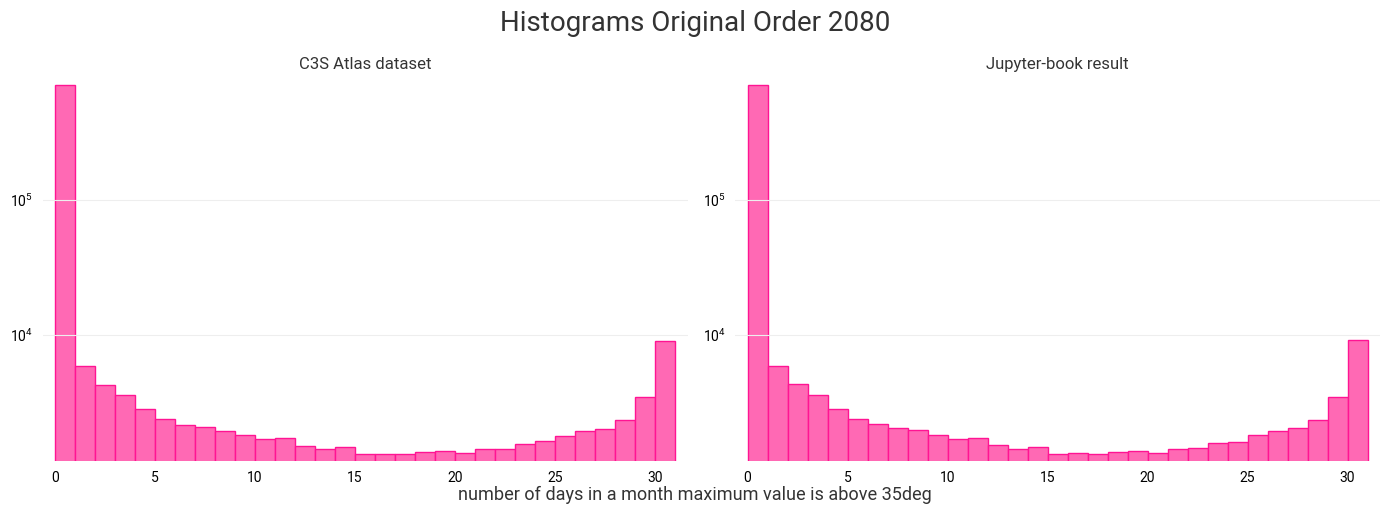

In [32]:
# these plots show histograms of the tx35 values globally for the 2080 for the ORIGINAL order 
fig, ax = plt.subplots(1, 2, figsize = (14, 5), sharex = True)
ax[0].hist(ds_tx35_C3S_Atlas_member_year['tx35'].values.ravel(), bins = 31, log =True, color = "hotpink", ec = "deeppink")
ax[0].set_title("C3S Atlas dataset")
ax[1].hist(ds_tx35_i['tx35'].values.ravel(), bins = 31, log =True, color = "hotpink", ec = "deeppink")
ax[1].set_title("Jupyter-book result")
fig.text(0.5, 0, "number of days in a month maximum value is above 35deg", ha = "center", fontsize = 13)
fig.suptitle("Histograms Original Order 2080", fontsize = 20)
plt.tight_layout()
plt.show()

In [21]:
# NR test metrics ORIGINAL

atlas = ds_tx35_i['tx35']  #DataArray
jn = ds_tx35_C3S_Atlas_member_year['tx35']  #DataArray

lat_bounds = (35.5, 44.5)
lon_bounds = (-9.5, 3.5)

atlas_subset = atlas.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
jn_subset = jn.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))

# Align time - maybe use xr.align
common_time = np.intersect1d(atlas_subset['time'], jn_subset['time'])
atlas_subset = atlas_subset.sel(time=common_time)
jn_subset = jn_subset.sel(time=common_time)

atlas_flat = atlas_subset.values.flatten()
jn_flat = jn_subset.values.flatten()

# mask out NaNs
mask = ~np.isnan(atlas_flat) & ~np.isnan(jn_flat)
atlas_clean = atlas_flat[mask]
jn_clean = jn_flat[mask]

# calculate metrics
mae = mean_absolute_error(atlas_clean, jn_clean)
rmse = np.sqrt(mean_squared_error(atlas_clean, jn_clean))
correlation = np.corrcoef(atlas_clean, jn_clean)[0, 1]

print(f"MAE Original: {mae:.4f}")
print(f"RMSE Original: {rmse:.4f}")
print(f"Correlation Original: {correlation:.4f}")


MAE Original: 0.0018
RMSE Original: 0.0423
Correlation Original: 1.0000


(section-8)=
### 8. Compare the results 

#### Results Subsections
Describe what is done in this step/section and what the `code` in the cell does (if code is included). 

If this is the **results section**, we expect the final plots to be created here with a description of how to interpret them, and what information can be extracted for the specific use case and user question. The information in the 'quality assessment statement' should be derived here. 

/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/earthkit/plots/metadata/labels.py:131: UserWarning: No key "variable_name" found in layer metadata.
  warnings.warn(f'No key "{attr}" found in layer metadata.')


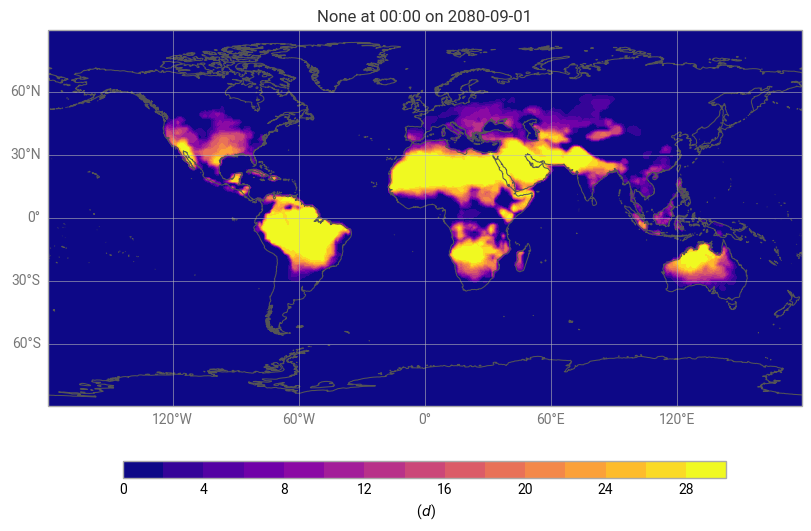

In [24]:
import earthkit.plots as ekp  #make all plots with earthkit 
# this plot shows the CMIP origin tx35 values 
ekp.quickplot(ds_tx35_i.sel(time="20800901"))

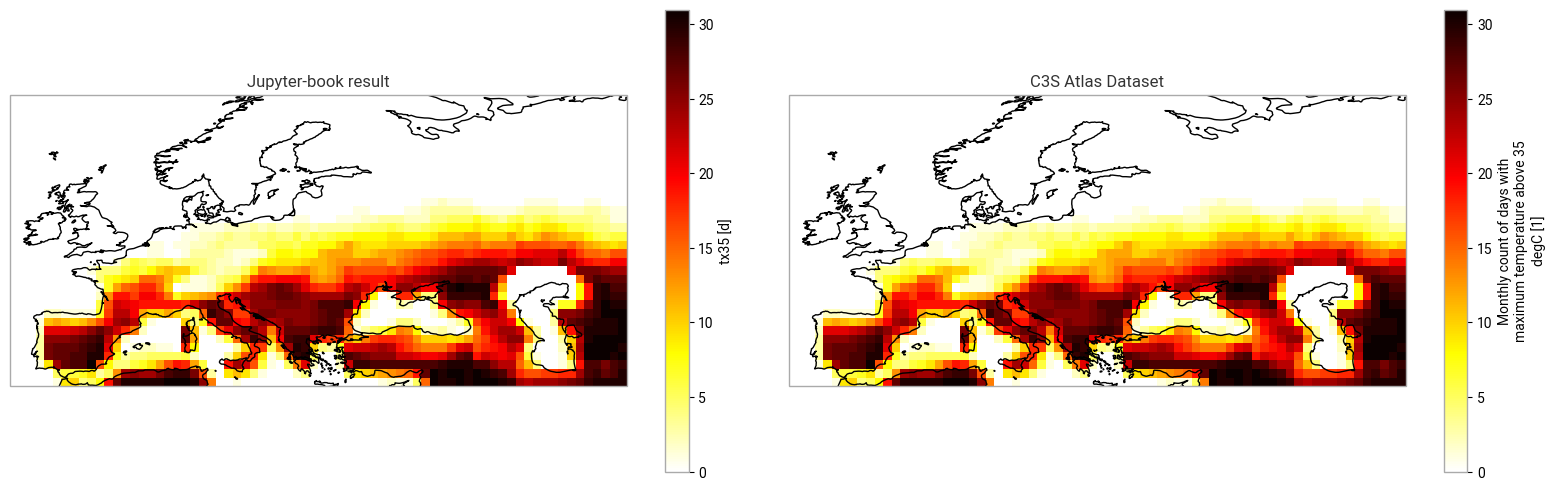

In [26]:
# Plot results ORIGINAL 

#zoomin_extent = [-9.5, 3.5, 35.5, 44.5] # Spain
zoomin_extent = [60, -12, 65, 35]   # Europe lon_min lon_max north south
month = 8 

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': proj}, figsize=(20, 6))

# from atlas use tools
plot_month(ax[0], ds_tx35_i, 'tx35', month, 'Jupyter-book result', 'hot_r')
ax[0].set_extent(zoomin_extent)

# workflow (intermediate dataset)
plot_month(ax[1], ds_tx35_C3S_Atlas_member_year, 'tx35', month, 'C3S Atlas Dataset', 'hot_r')
ax[1].set_extent(zoomin_extent)
plt.subplots_adjust(wspace=0.01, hspace=0.1) 

In [ ]:
diff = ds_tx35_i - ds_tx35_C3S_Atlas_member_year
# this histogram show the tx35 values for the CMIP6 origin dataset
where_diff_pos = ds_tx35_i.where(diff["tx35"] < 0) # values in ds_tx35 _i where the difference is more than 0 
plt.hist(where_diff_pos['tx35'].values.ravel(), bins = 31) # this histogram 


# this histogram shows the distribution of the value of the difference 
#plt.hist(diff['tx35'].where(diff["tx35"] != 0).values.ravel(), bins = 62)

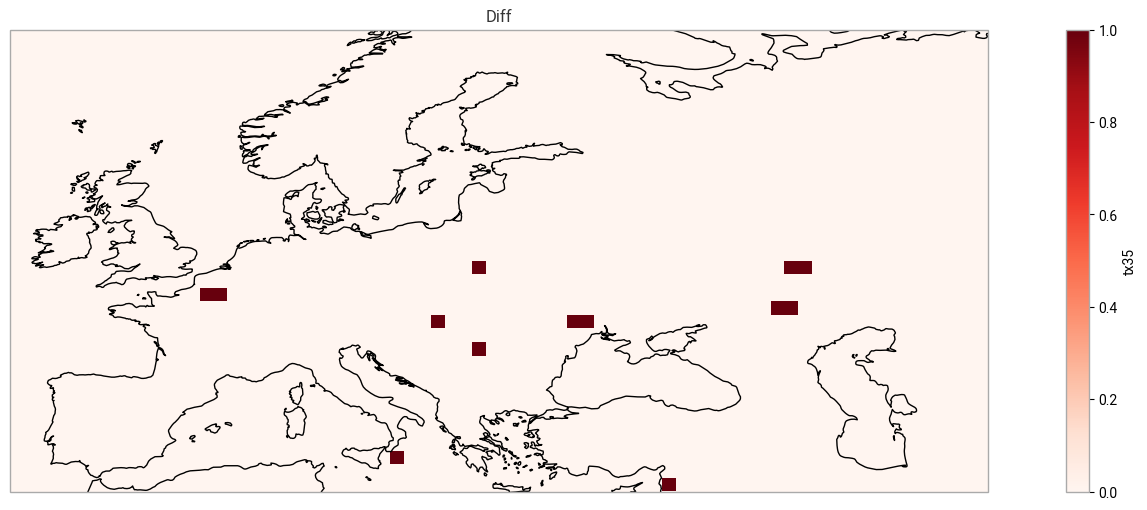

In [30]:
# difference plot 

diff = ds_tx35_i - ds_tx35_C3S_Atlas_member_year
fig, ax = plt.subplots(figsize=(20, 6), subplot_kw = {'projection': proj})
plot_month(ax, diff, 'tx35', 8, 'Diff', 'Reds')

ax.set_extent(zoomin_extent)

plt.show()

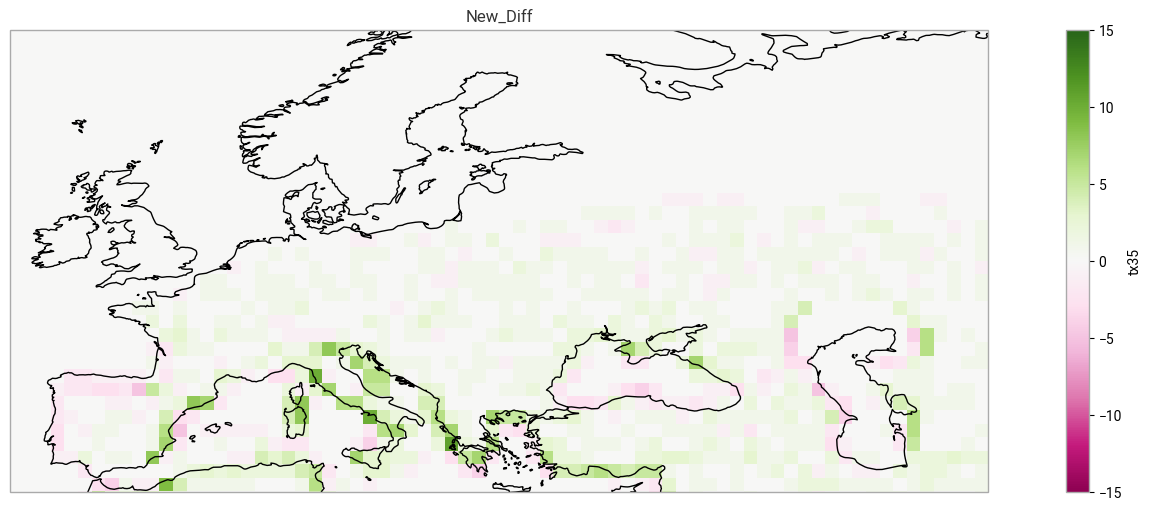

In [29]:
# new order interpolate first, then calculate index

# Step 1: Wrap tasmax in a Dataset
new_tasmax_ds = xr.Dataset({'tasmax': data['tasmax']})

# Step 2: Set up interpolation attributes
new_int_attr = {
    'interpolation_method': 'conservative_normed',
    'lats': np.arange(-89.5, 90.5, 1),
    'lons': np.arange(-179.5, 180.5, 1),
    'var_name': 'tasmax'
}

new_INTER = xesmfCICA.Interpolator(new_int_attr)

# Step 3: Interpolate the tasmax dataset
new_tasmax_interp_ds = new_INTER(new_tasmax_ds)

# Step 4: Calculate tx35 index on interpolated tasmax
new_da_tx35 = xclim.indices.tx_days_above(new_tasmax_interp_ds['tasmax'], 
    thresh='35.0 degC',
    freq='MS' # Monthly frequency
)

# # Step 5: Convert to Dataset
new_ds_tx35_i = new_da_tx35.to_dataset(name='tx35')

# NR test metrics new

atlas_new = new_ds_tx35_i['tx35']  #DataArray
jn_new = ds_tx35_C3S_Atlas_member_year['tx35']  #DataArray

lat_bounds = (35.5, 44.5)
lon_bounds = (-9.5, 3.5)

new_atlas_subset = atlas_new.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
new_jn_subset = jn_new.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))

# Align time - maybe use xr.align
new_common_time = np.intersect1d(new_atlas_subset['time'], new_jn_subset['time'])
new_atlas_subset = new_atlas_subset.sel(time=common_time)
new_jn_subset = new_jn_subset.sel(time=common_time)

new_atlas_flat = new_atlas_subset.values.flatten()
new_jn_flat = new_jn_subset.values.flatten()

# mask out NaNs
new_mask = ~np.isnan(new_atlas_flat) & ~np.isnan(new_jn_flat)
new_atlas_clean = new_atlas_flat[new_mask]
new_jn_clean = new_jn_flat[new_mask]

# calculate metrics
new_mae = mean_absolute_error(new_atlas_clean, new_jn_clean)
new_rmse = np.sqrt(mean_squared_error(new_atlas_clean, new_jn_clean))
new_correlation = np.corrcoef(new_atlas_clean, new_jn_clean)[0, 1]

print(f"New MAE: {new_mae:.4f}")
print(f"New RMSE: {new_rmse:.4f}")
print(f"new Correlation: {new_correlation:.4f}")


# these plots show histograms of the tx35 values globally for the 2080 for the NEW order 
fig, ax = plt.subplots(1, 2, figsize = (14, 5), sharex = True)
ax[0].hist(ds_tx35_C3S_Atlas_member_year['tx35'].values.ravel(), bins = 31, log =True, color = "hotpink", ec = "deeppink")
ax[0].set_title("C3S Atlas dataset")
ax[1].hist(new_ds_tx35_i['tx35'].values.ravel(), bins = 31, log =True, color = "hotpink", ec = "deeppink")
ax[1].set_title("Jupyter-book result")
fig.text(0.5, 0, "number of days in a month maximum value is above 35deg", ha = "center", fontsize = 13)
fig.suptitle("Histograms New Order 2080", fontsize = 20)
plt.tight_layout()
plt.show()



# Plot results NEW

#zoomin_extent = [-9.5, 3.5, 35.5, 44.5] # Spain
zoomin_extent = [60, -12, 65, 35]   # Europe lon_min lon_max north south
month = 8 

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': proj}, figsize=(20, 6))

# from atlas use tools
plot_month(ax[0], new_ds_tx35_i, 'tx35', month, 'Jupyter-book result', 'hot_r')
ax[0].set_extent(zoomin_extent)

# workflow (intermediate dataset)
plot_month(ax[1], ds_tx35_C3S_Atlas_member_year, 'tx35', month, 'C3S Atlas Dataset', 'hot_r')
ax[1].set_extent(zoomin_extent)
plt.subplots_adjust(wspace=0.01, hspace=0.1) 


# difference plot NEW

new_diff = new_ds_tx35_i - ds_tx35_C3S_Atlas_member_year
fig, ax = plt.subplots(figsize=(20, 6), subplot_kw = {'projection': proj})
plot_month(ax, new_diff, 'tx35', 8, 'New_Diff', 'PiYG')

ax.set_extent(zoomin_extent)

plt.show()

Part 1: This will be an example case for the tx35 index:
- a case where the difference is zero
- a case where there is a difference
- explanation of each step
- explantation of the metrics

Part 2: 

## ℹ️ If you want to know more

### Key resources

List some key resources related to this assessment. E.g. CDS entries, applications, dataset documentation, external pages.
Also list any code libraries used (if applicable).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

List the references used in the Notebook here.

E.g.

[[1]](https://doi.org/10.1038/s41598-018-20628-2) Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.